In [1]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("GridOperations.jl")
include("Temperature.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [2]:
function initial_ice_depth(x::Float64,options::Dict)
    return options["ice thickness"] + options["amplitude"]*cos( (pi*(x-options["wavelength"]))/options["wavelength"] )
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/molK)
    meltingpoint_viscosity = 1e15
    ice_vis = meltingpoint_viscosity*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = meltingpoint_viscosity
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else
        ice_vis = ice_vis
    end
    return ice_vis
end

struct Materials
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0],[1e3],[0.0],[2.1e3],[2.2])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    S = markers.scalarFields["S"]   
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if markers.scalars[S,i] > 0.0
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        else
            markers.scalars[eta,i] = 1e12
        end
    end
end

function update_marker_T_X!(markers::Markers,materials::Materials,options::Dict)
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]    
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[T,i],markers.scalars[X,i] = compute_T_X_from_S((markers.scalars[S,i]),options)
    end
end

# function update_marker_temp!(markers::Markers,materials::Materials)
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark
#         if mmat[i] == 1
#             markers.scalars[T,i] = 273.0
#         elseif mmat[i] == 3
#             markers.scalars[T,i] = 100.0
#         end
#     end
# end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options)
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 273.0
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 100.0+((273.0-100.0)/hice)*(my)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)           
        end
    end
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + ((grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j]))*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
include("TemperatureEntropy.jl")

subgirdSdiff! (generic function with 1 method)

In [3]:
function model_run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["amplitude"] + options["ice thickness"]/2
    ny = 50
    nx = 51 #Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113

    # -1 = insulating, 1 = constant temp 
    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # 1 Myr 
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Grid resolution(ny x nx) : $ny x $nx")
    println("Cell size in the x-direction is $(grid.W/(grid.nx-1))")
    println("Cell size in the y-direction is $(grid.H/(grid.ny-1))")

    materials = Materials()
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal","S","X"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers,materials,options)

    local ice_shell_thickness = []
    local time_plot = []

    ### Setting up agruments for interface function ###
    Ai = options["amplitude"]

    ### Setting up agruments for termination criteria ###
    max_step::Int64=10
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = dtmax

    local cdt = dt

    rho_c = nothing
    rho_vx = nothing
    rho_vy = nothing
    kThermal_vx = nothing
    kThermal_vy = nothing
    eta_s = nothing
    eta_n = nothing
    vxc = nothing
    vyc = nothing
    alpha = nothing
    Hr = nothing
    Cp_c = nothing
    dTmax = nothing
    dTemp = nothing
    Tnew = nothing
    Tlast = nothing
    Snew = nothing
    Slast = nothing
    Xnew = nothing
    Xlast = nothing
    q_vx = nothing
    q_vy = nothing
    Af = nothing 

    itime = 1
    output_dir = "test2"

    terminate = false
    while !terminate
        
        ### update the markers properties ###
        update_marker_prop!(markers,materials)
        ### Transfer properties markers -> nodes ###
        # Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic",method="logarithmic")
        # Cell Centers
        rho_c_new,Cp_c_new,alpha_new,Hr_new,kThermal_new,Slast_new,Xlast_new = marker_to_stag(markers,grid,["rho","Cp","alpha","Hr","kThermal","S","X"],"center")
        eta_n_new, = marker_to_stag(markers,grid,["eta",],"center",method="logarithmic")
        # interpolate temperature using rhocp as weight
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        # Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        kThermal_vx_new, = marker_to_stag(markers,grid,["kThermal",],"vx")
        kThermal_vy_new, = marker_to_stag(markers,grid,["kThermal",],"vy")

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal_vx,kThermal_vx_new)
            replace_nan!(kThermal_vy,kThermal_vy_new)
            replace_nan!(Slast,Slast_new)
            replace_nan!(Xlast,Xlast_new)
        end
        # Copy field data
        kThermal_vx = copy(kThermal_vx_new)
        kThermal_vy = copy(kThermal_vy_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
        Slast = copy(Slast_new)
        Xlast = copy(Xlast_new)

        Tlast,Xlast = update_T_X_from_S(Slast,options)
        Tlast,Xlast,Slast = ghost_nodes_center_TXS(grid,Tlast,Xlast,Slast,Tbctype,Tbcval,options) 
        
        # Initial guess for S
        Snew = copy(Slast)
        # Initial guess for T
        Tnew,Xnew = update_T_X_from_S(Snew,options)
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Slast,Tbctype,Tbcval,options)

        # Assembling and solving the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=0.0)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Obtaining velocity at the cell centers
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        diffusion_timestep = calculate_diffusion_timestep(grid,options)
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        if this_dtmax > diffusion_timestep
            dt = diffusion_timestep
        else 
            dt = this_dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        if itime == 1   
            println("Diffusion timestep is ",diffusion_timestep/seconds_in_year," yr, ",diffusion_timestep/seconds_in_year/1e3," Kyr, ",diffusion_timestep/seconds_in_year/1e6," Myr")
            println("Starting step $itime, with dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
            figure()
            title(L"Initial\,Melt\,Fraction")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xnew,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xnew)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 
        elseif cdt != dt && false
            println("Starting step $itime, with dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
        end
        
        last_T_norm = NaN
        T_norm = NaN
        dT = nothing
        dTmax = Inf
        dS = nothing
        dSmax = Inf
        tolerance = 1e-8
        dTnorm = []
        ititer = []
        titer = 1 
        max_titer = 100
        for titer=1:max_titer

            # println("Starting iteration $titer, with timestep = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")            
            
            # Computing conductive heat flux
            q_vx,q_vy = compute_q_cond(grid,Tnew,kThermal_vx,kThermal_vy) # W/m^2

            # Computing the new entropy
            Snew = compute_S_new(grid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,dt);

            # Updating the new temperature and new melt fraction from the new entropy
            Tnew,Xnew = update_T_X_from_S(Snew,options)
            Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
            
            if titer > 1
                last_T_norm = T_norm;
                T_norm = norm(Tnew)
                # T_norm = norm(Tnew[2:grid.ny,2:grid.nx]);
                # println("[",titer,"]: Change in norm is :",abs(T_norm-last_T_norm))
                push!(dTnorm,abs(T_norm-last_T_norm))
                push!(ititer,titer)
            else
                T_norm = norm(Tnew)
                # T_norm = norm(Tnew[2:grid.ny,2:grid.nx]);
                # T_norm = norm(Tnew[2:end-1,2:end-1]);
                push!(dTnorm,abs(T_norm-last_T_norm))
                push!(ititer,titer)
            end

            # Computing the maximum temperature change
            dT = Tnew - Tlast
            dTmax = maximum(abs.(dT[2:grid.ny,2:grid.nx]))
            # println("Maximum temperature change = $dTmax K")

            # Computing the maximum entropy change
            dS = Snew - Slast
            dSmax = maximum(abs.(dS[2:grid.ny,2:grid.nx]))
            # println("Maximum Entropy change = $dSmax J/K")

            # # Printing dt
            # println("dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
            # dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            
            # Checking for convergence:
            if titer > 1 && abs(T_norm-last_T_norm) < tolerance
                # println("Converged after $titer iterations.")
                break
            elseif titer == max_titer
                terminate = true
                # error("Did not converged")
                @error("Did not converged")
            elseif any(isnan.(dT))
                terminate = true
                # error("NaN or Inf apperred")
                @error("NaN or Inf apperred")
            end       
        end

        # Updating entropy on the markers by projecting dS from the cell centers to the markers
        # cell_center_change_to_markers!(markers,grid,dS,"S")
        dS_subgrid_node = subgirdSdiff!(markers,materials,grid,Slast,dS,dT,dt,options)
        dS_remaining = dS - dS_subgrid_node
        cell_center_change_to_markers!(markers,grid,dS_remaining,"S")

       
        
        ### Setting up agruments for Termination Criteria ###
        melt_fraction_contour = get_interface(grid,-Xnew,-0.5)
        max_ice_shell_thickness = maximum(melt_fraction_contour)
        avg_ice_shell_thickness = mean(melt_fraction_contour)
        append!(ice_shell_thickness,avg_ice_shell_thickness)
        append!(time_plot,time) 

        
        Af = max_ice_shell_thickness-avg_ice_shell_thickness
        i_A = @sprintf("%.6g",Ai/1e3)
        f_A = @sprintf("%.6g",Af/1e3)

        # Checking Termination Criteria, time is in Myr, amplitude is in meters
        if time >= max_time || itime >= max_step || Af/Ai <= 1/exp(1) || (ice_shell_thickness[itime] - ice_shell_thickness[1]) > 3e3
            terminate = true
            figure()
            title(L"Melt\,Fraction")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xnew,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xnew)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 
        end
        
        # if time == 0.0 || mod(itime,10) == 0 || terminate
        #     last_plot = time 
        #     # Gird output
        #     name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        #     println("Writing visualization file = ",name1)
        #     vn = velocity_to_basic_nodes(grid,vxc,vyc)
        #     visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year/1e3;filename=name1)
        #     # Markers output
        #     name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        #     println("Writing visualization file = ",name2)
        #     visualization(markers,time/seconds_in_year;filename=name2)
        #     # # Hydrostatic Pressure output
        #     # name3 = @sprintf("%s/hp.%04d.vtr",output_dir,iout)
        #     # println("Writing visualization file = ",name3)
        #     # output_fields = Dict("Hydrostatic Pressure"=>hp[2:end-1,2:end-1])
        #     # visualization(grid,output_fields,time/seconds_in_year;filename=name3)
        #     iout += 1
        # end

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        if mod(itime,100) == 0
            ice_shell = (ice_shell_thickness[itime] - ice_shell_thickness[1])
            ice_shell = @sprintf("%.6g",ice_shell/1e3)
            println("Initial Amplitude: $i_A (km), Final amplitude: $f_A (km)")
            println("Ice shell as thicken by $ice_shell (km)")
            println("Finished step $itime")
            println("time = ",time/seconds_in_year," yr, ",time/seconds_in_year/1e3," Kyr, ",time/seconds_in_year/1e6," Myr") 
        end
        itime += 1
    end
    return grid,time,time_plot,ice_shell_thickness,itime
end

model_run (generic function with 1 method)

Grid resolution(ny x nx) : 50 x 51
Cell size in the x-direction is 400.0
Cell size in the y-direction is 367.3469387755102
Creating Markers...
  0.001940 seconds (19 allocations: 10.701 MiB)
Initial condition...
  0.227384 seconds (2.44 M allocations: 39.425 MiB, 9.02% gc time, 43.45% compilation time)
Diffusion timestep is 408.9205255386012 yr, 0.4089205255386012 Kyr, 0.00040892052553860125 Myr
Starting step 1, with dt = 408.9205255386012 yr, 0.4089205255386012 Kyr, 0.00040892052553860125 Myr


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error: NaN or Inf apperred
└ @ Main In[3]:250
┌ Error

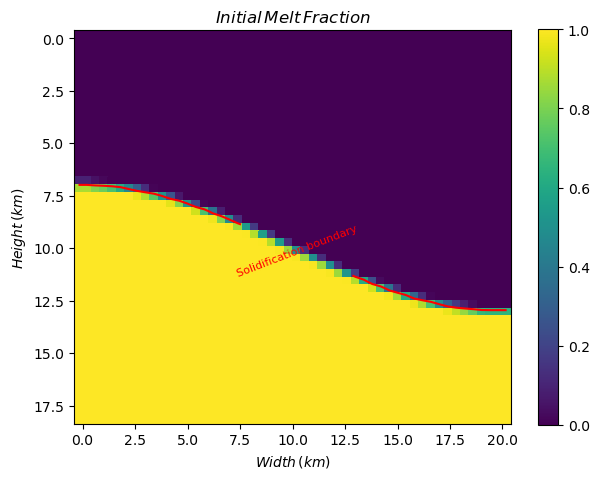

In [4]:
options = Dict()
options["ice thickness"] = 10e3
options["ym"] = options["ice thickness"]
options["wavelength"] = 20e3
options["amplitude"] = 0.3*options["ice thickness"]
options["latent heat of fusion"] = 3.34e5 #J/kg
options["specific heat of ice"] = 2.1e3 # J/kg*K (ice)
options["density of ice"] = 1e3 # kg/m^3
options["thermal conductivity of ice"] = 2.2 # W/m*K
options["thermal diffusivity"] = options["thermal conductivity of ice"] / (options["density of ice"]*options["specific heat of ice"]) # m^2/s
options["Tm"] = 273.0 # K
grid,time,time_plot,ice_shell_thickness,itime = model_run(options);

In [ ]:
# Profile of ice-water inferface topograpgy over time from melt fraction
figure()
for i in 1:1000:itime-1
    plot(grid.xc/1e3,X_contour_array[i]/1e3,label=(L"At",@sprintf("%.3g",time_plot[i]/3.15e7/1e6),L"Myr"))
end
title(L"Position\,\,of\,\,Solidified\,\,Layer\,\,Over\,\,Time")
gca().invert_yaxis()
# Legend is at the bottom
legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

In [ ]:
options["To"] = 100.0
lambda1 = get_lambda1(options)
t = get_t(lambda1,options)
y = get_y.(lambda1,time_plot.+t,Ref(options))
figure()
plot(time_plot/3.15e7/1e6,y/1e3,"b-",label="Stefan Solution")
plot(time_plot/3.15e7/1e6,ice_shell_thickness/1e3,"r--",label="Numerical Solution from Melt Fraction contour")
gca().set_ylabel(L"Ice\,Thickness\,(km)")
gca().set_xlabel(L"Time\,(Myr)")
legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

In [ ]:
# t_halfspace = get_halfspace_time_viscous(options["wavelength"])
# t_rel = get_numerical_time_viscous(options["amplitude"],Xf_contour,time)
# rate = get_thickening_rate(options["ice thickness"])
# t_thickening = get_thickening_time(options["amplitude"],rate)
# println("Analytic relaxation time: ",t_halfspace/1e3,"(kyr) or ",t_halfspace/1e6,"(Myr)")
# println("Numerical relaxation time: ",t_rel/1e3,"(kyr) or ",t_rel/1e6,"(Myr)")
# println("Thickening time: ",t_thickening/1e3,"(kyr) or ",t_thickening/1e6,"(Myr)")